# Library imports

In [1]:
! pip install geocoder

     |████████████████████████████████| 102kB 7.7MB/s ta 0:00:011


In [2]:
import geocoder

In [3]:
import pandas as pd

In [4]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [119]:
import statsmodels.api as sm

In [154]:
import seaborn as sns
import numpy as np

# Washington crimes data

First of all, we obtain the Washington crimes dataset

In [5]:
url = 'https://opendata.arcgis.com/datasets/38ba41dd74354563bce28a359b59324e_0.csv'

In [6]:
crimes_df = pd.read_csv(url)
crimes_df.head()

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
0,-76.984594,38.879114,18206448,2018-12-05T15:29:29.000Z,EVENING,OTHERS,THEFT/OTHER,1400 - 1499 BLOCK OF IVES PLACE SE,401337.00,134586.00,...,007100 2,7100.0,Precinct 91,38.879106,-76.984591,NaN,2018-12-05T14:30:50.000Z,2018-12-05T15:00:32.000Z,430803211,18206448-01
1,-76.992649,38.883673,18206449,2018-12-05T15:20:17.000Z,EVENING,OTHERS,THEFT F/AUTO,400 - 449 BLOCK OF 10TH STREET SE,400638.00,135092.00,...,006900 1,6900.0,Precinct 90,38.883665,-76.992647,CAPITOL HILL,2018-12-05T02:00:03.000Z,2018-12-05T13:30:52.000Z,430803212,18206449-01
2,-77.032594,38.928179,18206454,2018-12-05T16:00:00.000Z,EVENING,OTHERS,THEFT/OTHER,3000 - 3099 BLOCK OF 14TH STREET NW,397174.00,140033.00,...,002802 1,2802.0,Precinct 36,38.928171,-77.032592,NaN,2018-12-05T14:53:42.000Z,2018-12-05T16:00:11.000Z,430803213,18206454-01
3,-77.025607,38.934585,18206456,2018-12-05T15:33:05.000Z,EVENING,OTHERS,THEFT/OTHER,3600 - 3639 BLOCK OF NEW HAMPSHIRE AVENUE NW,397780.00,140744.00,...,002900 1,2900.0,Precinct 42,38.934577,-77.025605,NaN,2018-12-05T15:01:14.000Z,2018-12-05T15:28:44.000Z,430803214,18206456-01
4,-77.058083,38.934832,18206460,2018-12-05T15:44:41.000Z,EVENING,OTHERS,THEFT/OTHER,3319 - 3499 BLOCK OF CONNECTICUT AVENUE NW,394964.33,140772.69,...,001302 2,1302.0,Precinct 27,38.934824,-77.058081,NaN,2018-12-05T15:05:40.000Z,2018-12-05T15:13:03.000Z,430803215,18206460-01


As far as we plan to calculate regression, we need to check the count of available samples:

In [7]:
crimes_df.shape[0]

1641

Let's check the column names in this dataset

In [8]:
crimes_df.columns

Index(['X', 'Y', 'CCN', 'REPORT_DAT', 'SHIFT', 'METHOD', 'OFFENSE', 'BLOCK',
       'XBLOCK', 'YBLOCK', 'WARD', 'ANC', 'DISTRICT', 'PSA',
       'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'BID', 'START_DATE',
       'END_DATE', 'OBJECTID', 'OCTO_RECORD_ID'],
      dtype='object')

From here, we need only NEIGHBORHOOD_CLUSTER and OFFENSE columns

In [9]:
crimes_df = crimes_df.loc[:, ('NEIGHBORHOOD_CLUSTER', 'OFFENSE')]

We will rename the columns for convenience and check the result

In [10]:
crimes_df.columns = ['cluster','crime']

In [11]:
crimes_df.head()

,cluster,crime
0,Cluster 26,THEFT/OTHER
1,Cluster 26,THEFT F/AUTO
2,Cluster 2,THEFT/OTHER
3,Cluster 2,THEFT/OTHER
4,Cluster 15,THEFT/OTHER


Let's see what kinds of crimes were recorded

In [12]:
pd.unique(crimes_df['crime'])

array(['THEFT/OTHER', 'THEFT F/AUTO', 'BURGLARY', 'MOTOR VEHICLE THEFT',
       'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY', 'HOMICIDE', 'SEX ABUSE',
       'ARSON'], dtype=object)

The crime names are not very standard, so we'll need to manually match them manually to the severity scores and add to the dataset

In [13]:
# the scores taken from here: 
# https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/crimeseverityscoreexperimentalstatistics
weights = {
    'SEX ABUSE':3254, # rape 
    'HOMICIDE':7973, 
    'THEFT F/AUTO':33, 
    'THEFT/OTHER':37,
    'ASSAULT W/DANGEROUS WEAPON':2035, 
    'BURGLARY':465, 
    'ROBBERY':800,
    'MOTOR VEHICLE THEFT':128, 
    'ARSON':442
}

In [14]:
crimes_df['score'] = crimes_df['crime'].map(weights)

In addition, in the crimes dataset, we have only neighborhood clusters, and in the Foursquare venues database, it is more convenient to have Neighborhoods with their shape.

Therefore, we first need to map neighborhood clusters to neighborhood names.

In [8]:
# to match cluster id and neighb names
cluster_names_url = 'https://opendata.arcgis.com/datasets/f6c703ebe2534fc3800609a07bad8f5b_17.csv'
cluster_names_df = pd.read_csv(cluster_names_url)
cluster_names_df.head()

,OBJECTID,WEB_URL,NAME,NBH_NAMES,Shape_Length,Shape_Area,TYPE
0,1,http://planning.dc.gov/,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",10711.668010,4.886463e+06,Original
1,2,http://planning.dc.gov/,Cluster 38,"Douglas, Shipley Terrace",8229.486324,2.367958e+06,Original
2,3,http://planning.dc.gov/,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",4746.344457,1.119573e+06,Original
3,4,http://planning.dc.gov/,Cluster 27,"Near Southeast, Navy Yard",7286.968902,1.619167e+06,Original
4,5,http://planning.dc.gov/,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,Original


The total cluster count is as follows

In [9]:
cluster_names_df.shape[0]

46

The available Neighborhood cluster dataset contains multiple neighborhoods per single cell, so we'll make a separate function to split them

In [16]:
def split_neigh(df):
    neigs = []
    clusters = []
    for row in df.iterrows():
        for nbh in row[1]['NBH_NAMES'].split(', '):
            neigs.append(nbh)
            clusters.append(row[1]['NAME'])
    out_df = pd.DataFrame({'neighborhood':neigs, 'cluster':clusters})
    return out_df

In [17]:
cluster_names_df = split_neigh(cluster_names_df)
cluster_names_df.head()

,neighborhood,cluster
0,Congress Heights,Cluster 39
1,Bellevue,Cluster 39
2,Washington Highlands,Cluster 39
3,Douglas,Cluster 38
4,Shipley Terrace,Cluster 38


Now, we need to obtain the coordinates of each neighborhood. We will use the geocoder library for this. As far as the Google Maps API requires a subscription, we will use the free ArcGIS API

In [18]:
def get_coordinates(neighb):

    g = geocoder.arcgis('{}, Washington DC, US'.format(neighb))
    result = g.json

    latitude = result['lat']
    longitude = result['lng']
    return latitude, longitude

In [19]:
cluster_names_df['latitude'] = 0
cluster_names_df['longitude'] = 0

In [32]:
coords = cluster_names_df['neighborhood'].apply(get_coordinates)
cluster_names_df.loc[:,'latitude'] = [x[0] for x in coords]
cluster_names_df.loc[:,'longitude'] = [x[1] for x in coords]
cluster_names_df.head()

,neighborhood,cluster,latitude,longitude
0,Congress Heights,Cluster 39,38.842900,-77.000570
1,Bellevue,Cluster 39,38.826540,-77.008700
2,Washington Highlands,Cluster 39,38.831980,-76.997000
3,Douglas,Cluster 38,38.923443,-77.000071
4,Shipley Terrace,Cluster 38,38.847340,-76.972930


# Foursquare data

To this end, we have a list of Washington DC Neighborhoods, and now we want to obtain a count of culture, sports, and spiritual objects first for each neighborhood, and then for the neighborhood clusters. For this task, we will use the Foursquare api.

In [34]:
VERSION = '20180605' # Foursquare API version

In [35]:
LIMIT = 100

The function below will obtain a list of all venues near approximately belonging to the neighborhood. In addition, it will store the venue category id to filter the required venue types later.

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
#         json = requests.get(url).json()
#         print(json)
#         break
        results = requests.get(url).json()["response"]['groups'][0]['items']
#         results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category',
                  'venue_category_id']
    
    return(nearby_venues)

In [64]:
washington_venues = getNearbyVenues(names=cluster_names_df['neighborhood'],
                                   latitudes=cluster_names_df['latitude'],
                                   longitudes=cluster_names_df['longitude']
                                  )
washington_venues.head()

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,venue_category_id
0,Congress Heights,38.8429,-77.00057,MLK Deli,38.843560,-76.999808,Deli / Bodega,4bf58dd8d48988d146941735
1,Congress Heights,38.8429,-77.00057,Malcolm X and MLK,38.843144,-76.998744,Road,4bf58dd8d48988d1f9931735
2,Congress Heights,38.8429,-77.00057,Alabama and MLK Ave SE,38.843196,-76.998774,Intersection,52f2ab2ebcbc57f1066b8b4c
3,Congress Heights,38.8429,-77.00057,Popeyes Louisiana Kitchen,38.844926,-76.997012,Fried Chicken Joint,4d4ae6fc7a7b7dea34424761
4,Congress Heights,38.8429,-77.00057,Capital City Creamery,38.844296,-76.998362,Ice Cream Shop,4bf58dd8d48988d1c9941735


Now we will obtain the list of all available categories from the Fourquare. This is required, as the categories could be nested, and we also need the subcategories for the filter to work correctly

In [71]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION
)

# make the GET request
results = requests.get(url).json()["response"]['categories']

Now we define a function to recursively scan the obtained categories and save only those belonging to the supplied category id list or being the appropriate subcategories

In [78]:
def store_categories(results, target_ids, is_subtopic=False):    
    output=[]
    for category in results:        
        if category['id'] in target_ids:            
            output.append(category['id'])
            if category['categories'] != []:
                output.extend(store_categories(category['categories'], target_ids, is_subtopic=True))
        else:
            if is_subtopic:
                output.append(category['id'])
                if category['categories'] != []:
                    output.extend(store_categories(category['categories'], target_ids, is_subtopic=True))
            else:
                if category['categories'] != []:
                    output.extend(store_categories(category['categories'], target_ids, is_subtopic=False))
    return output

Now we define the base categories list and perform the filtering

In [86]:
categories_culture = {'Art Gallery':'4bf58dd8d48988d1e2931735',
    'Concert Hall':'5032792091d4c4b30a586d5c',
    'Museum':'4bf58dd8d48988d181941735'}
categories_sports = {'Stadium':'4bf58dd8d48988d184941735',
    'College Stadium':'4bf58dd8d48988d1b4941735',
    'Gym / Fitness Center':'4bf58dd8d48988d175941735',
    'College Gym':'4bf58dd8d48988d1b2941735'}
categories_church = {'Spiritual Center':'4bf58dd8d48988d131941735'}

In [87]:
sports_list = store_categories(results, list(categories_sports.values()))
culture_list = store_categories(results, list(categories_culture.values()))
church_list = store_categories(results, list(categories_church.values()))

Now we convert the category ids of the obtained venues and remove those venues, which do not have an assigned category from our lists

In [88]:
def label_category(category_id):
    if category_id in sports_list:
        return 'sport'
    if category_id in culture_list:
        return 'culture'
    if category_id in church_list:
        return 'church'
    return None

In [89]:
washington_venues['category_group'] = washington_venues['venue_category_id'].apply(label_category)
washington_venues.head()

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,venue_category_id,category_group
0,Congress Heights,38.8429,-77.00057,MLK Deli,38.843560,-76.999808,Deli / Bodega,4bf58dd8d48988d146941735,None
1,Congress Heights,38.8429,-77.00057,Malcolm X and MLK,38.843144,-76.998744,Road,4bf58dd8d48988d1f9931735,None
2,Congress Heights,38.8429,-77.00057,Alabama and MLK Ave SE,38.843196,-76.998774,Intersection,52f2ab2ebcbc57f1066b8b4c,None
3,Congress Heights,38.8429,-77.00057,Popeyes Louisiana Kitchen,38.844926,-76.997012,Fried Chicken Joint,4d4ae6fc7a7b7dea34424761,None
4,Congress Heights,38.8429,-77.00057,Capital City Creamery,38.844296,-76.998362,Ice Cream Shop,4bf58dd8d48988d1c9941735,None


In [91]:
washington_venues.dropna(inplace=True)

Now we calculate the venue count for each venue type (church, sports and culture) for each neighborhood

In [100]:
venues_counts = washington_venues.groupby(
    by=['neighborhood','category_group'], as_index=False)['venue_category_id'].agg({'count':'count'})

In [106]:
neighb_venues = pd.DataFrame()
for neigh in pd.unique(venues_counts['neighborhood']):
    new_row = {'neighborhood':neigh, 'sport':0,'culture':0,'church':0}
    for row in venues_counts[venues_counts['neighborhood'] == neigh].iterrows():
        new_row[row[1]['category_group']] = row[1]['count']
    neighb_venues = neighb_venues.append(new_row, ignore_index=True)
neighb_venues.head()

,church,culture,neighborhood,sport
0,0.0,1.0,Adams Morgan,2.0
1,0.0,0.0,Barnaby Woods,1.0
2,0.0,0.0,Bloomingdale,1.0
3,0.0,0.0,Brookland,1.0
4,0.0,0.0,Burrville,1.0


The next step is to merge the crimes dataset and the venue count dataset

In [108]:
crimes_df = pd.merge(crimes_df, neighb_venues, on='neighborhood', how='left')
crimes_df.head()

,cluster,crime,score,neighborhood,latitude,longitude,church,culture,sport
0,Cluster 26,THEFT/OTHER,37,Capitol Hill,38.88956,-77.00942,0.0,1.0,1.0
1,Cluster 26,THEFT/OTHER,37,Lincoln Park,38.88927,-76.99088,NaN,NaN,NaN
2,Cluster 26,THEFT F/AUTO,33,Capitol Hill,38.88956,-77.00942,0.0,1.0,1.0
3,Cluster 26,THEFT F/AUTO,33,Lincoln Park,38.88927,-76.99088,NaN,NaN,NaN
4,Cluster 2,THEFT/OTHER,37,Columbia Heights,38.92525,-77.02970,0.0,1.0,4.0


For some neighborhoods, there are no venues of the required category, so we'll replace the missing data with zeros

In [110]:
crimes_df = crimes_df.fillna(value=0)

Now we sum up the neighborhoods venues counts and crime scores within each cluster

In [112]:
clustered_crimes = crimes_df.groupby('cluster')[['score','church','culture','sport']].agg('sum')

Finally, we apply the ordinary least squares model (OLM) to the constructed data to estimate the influence of each venue type on the crimes severity, and test whether such influence is statistically significant

In [120]:
X = clustered_crimes[['church','culture','sport']]
X = sm.add_constant(X)
y = clustered_crimes['score']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     5.163
Date:                Tue, 21 Apr 2020   Prob (F-statistic):            0.00452
Time:                        21:06:15   Log-Likelihood:                -466.71
No. Observations:                  40   AIC:                             941.4
Df Residuals:                      36   BIC:                             948.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.662e+04   5749.002      4.630      0.000     1.5e+04    3.83e+04
church       641.5834    460.168      1.394      0.172    -291.681    1574.848
culture      -84.6749     39.947     -2.120      0.041    -165.691      -3.659
sport         89.6720     25.484      3.519      0.001      37.987     141.357
==============================================================================
Omnibus:                       12.877   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.027
Skew:                           1.219   Prob(JB):                      0.00148
Kurtosis:                       4.367   Cond. No.                         675.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First of all, we note that the model has quite low R-squared value, indicating that the count of the selected venues is not enough to explain the crime severities, or that the dependency is non-linear.

The t values for sports and culture object counts are below 0.05, so their influence is statistically significant. The t value for the churches count, on the other hand, is not, and thus churches' influence is not a statistically significant one.

The coefficient values indicate that the influence of sports venues on crime severity is positive, and culture objects count negative, as was expected. The sports objects have somewhat larger influence (the coefficient absolute value is 3.52 vs. 2.12 for the culture venues).

In addition, let's check, whether the frequency of particular crime types correlate with particular venue counts form our lists 

In [126]:
clustered_crime_types = crimes_df.groupby('crime', as_index=False)[['crime','church','culture','sport']].agg('sum')

In [145]:
clustered_crime_types.head()

,crime,church,culture,sport
0,ARSON,0.0,0.0,1.0
1,ASSAULT W/DANGEROUS WEAPON,2.0,92.0,236.0
2,BURGLARY,0.0,78.0,192.0
3,HOMICIDE,2.0,31.0,23.0
4,MOTOR VEHICLE THEFT,8.0,187.0,316.0


In [147]:
clustered_crime_types = pd.get_dummies(clustered_crime_types, columns=['crime'])

In [148]:
clustered_crime_types.corr()

,church,culture,sport,crime_ARSON,crime_ASSAULT W/DANGEROUS WEAPON,crime_BURGLARY,crime_HOMICIDE,crime_MOTOR VEHICLE THEFT,crime_ROBBERY,crime_SEX ABUSE,crime_THEFT F/AUTO,crime_THEFT/OTHER
church,1.000000,0.993894,0.984370,-0.201979,-0.185302,-0.201979,-0.185302,-0.135271,-0.151948,-0.201979,0.415077,0.848684
culture,0.993894,1.000000,0.997465,-0.217032,-0.183209,-0.188356,-0.205635,-0.148283,-0.140562,-0.213356,0.508696,0.787737
sport,0.984370,0.997465,1.000000,-0.236578,-0.162108,-0.176051,-0.229606,-0.136757,-0.133905,-0.229606,0.555653,0.748957
crime_ARSON,-0.201979,-0.217032,-0.236578,1.000000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000
crime_ASSAULT W/DANGEROUS WEAPON,-0.185302,-0.183209,-0.162108,-0.125000,1.000000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000
crime_BURGLARY,-0.201979,-0.188356,-0.176051,-0.125000,-0.125000,1.000000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000
crime_HOMICIDE,-0.185302,-0.205635,-0.229606,-0.125000,-0.125000,-0.125000,1.000000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000
crime_MOTOR VEHICLE THEFT,-0.135271,-0.148283,-0.136757,-0.125000,-0.125000,-0.125000,-0.125000,1.000000,-0.125000,-0.125000,-0.125000,-0.125000
crime_ROBBERY,-0.151948,-0.140562,-0.133905,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,1.000000,-0.125000,-0.125000,-0.125000
crime_SEX ABUSE,-0.201979,-0.213356,-0.229606,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,1.000000,-0.125000,-0.125000


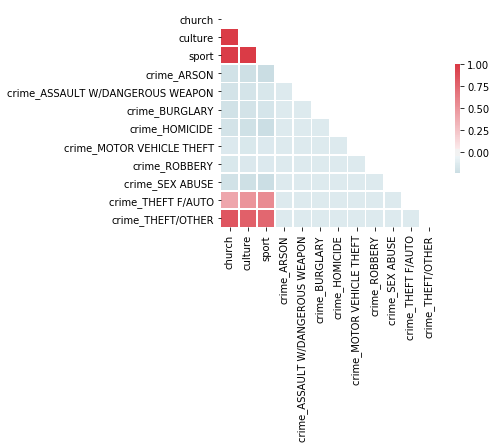

In [162]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(clustered_crime_types.corr(), dtype=np.bool))
sns.heatmap(clustered_crime_types.corr(), cmap=cmap, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From here, we note that the more culture- and sports-related venues we have, the more theft cases would be. This could be attributed to the mass people gathering places, in which theft could be easier to conduct. On the other hand, more severe crimes have a small negative correlation with such venues. 